In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
from zipfile import ZipFile
import warnings
import pickle
import torch
from torch.utils.data import Dataset
import tsfel
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import lightgbm as lgb
from hiclass import LocalClassifierPerNode, LocalClassifierPerParentNode, LocalClassifierPerLevel
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

# Data split

In [7]:
def create_folds(train_y, n_splits=10):
    # Create a label array for stratification
    # We'll use the first non-zero label for each row as the stratification target
    stratify_labels = []
    for _, row in train_y.iterrows():
        labels = row[train_y.columns != 'filename'].values
        # Get first non-negative label, or 0 if all negative
        first_positive = next((i for i, x in enumerate(labels) if x >= 0), 0)
        stratify_labels.append(first_positive)
    
    # Create StratifiedKFold object
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Generate fold indices
    folds = []
    for train_idx, val_idx in skf.split(train_y, stratify_labels):
        folds.append({
            'train': train_idx,
            'val': val_idx
        })
    
    return folds

### Preprocessing mixed level labels

In [8]:
train_y = pd.read_csv("../downloads/train_y_v0.1.0.csv")

In [39]:
train_y

,filename,Active_Power_Sensor,Air_Flow_Sensor,Air_Flow_Setpoint,Air_Temperature_Sensor,Air_Temperature_Setpoint,Alarm,Angle_Sensor,Average_Zone_Air_Temperature_Sensor,Chilled_Water_Differential_Temperature_Sensor,...,Warmest_Zone_Air_Temperature_Sensor,Water_Flow_Sensor,Water_Temperature_Sensor,Water_Temperature_Setpoint,Wind_Direction_Sensor,Wind_Speed_Sensor,Zone_Air_Dewpoint_Sensor,Zone_Air_Humidity_Sensor,Zone_Air_Humidity_Setpoint,Zone_Air_Temperature_Sensor
0,train_X0.pkl,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,train_X1.pkl,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,train_X2.pkl,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,train_X3.pkl,0,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,train_X4.pkl,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31834,train_X31846.pkl,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
31835,train_X31847.pkl,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
31836,train_X31848.pkl,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
31837,train_X31849.pkl,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [9]:
folds = create_folds(train_y)

# Prepare features

### Prepare pre-extracted features

In [10]:
raw_train_sets = [
    pd.read_csv("../downloads/train_data_features_v3_fixed/train_features_full_v3.csv"),
    pd.read_csv("../downloads/train_data_features_v3_fixed/train_features_split1_2_v3.csv"),
    pd.read_csv("../downloads/train_data_features_v3_fixed/train_features_split2_2_v3.csv"),
    pd.read_csv("../downloads/train_data_features_v3_fixed/train_features_split1_3_v3.csv"),
    pd.read_csv("../downloads/train_data_features_v3_fixed/train_features_split2_3_v3.csv"),
    pd.read_csv("../downloads/train_data_features_v3_fixed/train_features_split3_3_v3.csv"),
    pd.read_csv("../downloads/train_data_features_v3_fixed/train_features_split1_4_v3.csv"),
    pd.read_csv("../downloads/train_data_features_v3_fixed/train_features_split2_4_v3.csv"),
    pd.read_csv("../downloads/train_data_features_v3_fixed/train_features_split3_4_v3.csv"),
    pd.read_csv("../downloads/train_data_features_v3_fixed/train_features_split4_4_v3.csv")
]

In [11]:
raw_test_X = pd.read_csv("../downloads/test_features_full_v3.csv")

In [12]:
pre_feature_list = ['0_Absolute energy',
 '0_Area under the curve',
 '0_Autocorrelation',
 '0_Average power',
 '0_Centroid',
 '0_ECDF Percentile Count_0',
 '0_ECDF Percentile Count_1',
 '0_ECDF Percentile_0',
 '0_ECDF Percentile_1',
 '0_Entropy',
 '0_Histogram mode',
 '0_Interquartile range',
 '0_Kurtosis',
 '0_Max',
 '0_Mean',
 '0_Mean absolute deviation',
 '0_Mean absolute diff',
 '0_Mean diff',
 '0_Median',
 '0_Median absolute deviation',
 '0_Median absolute diff',
 '0_Median diff',
 '0_Min',
 '0_Negative turning points',
 '0_Neighbourhood peaks',
 '0_Peak to peak distance',
 '0_Positive turning points',
 '0_Root mean square',
 '0_Signal distance',
 '0_Skewness',
 '0_Slope',
 '0_Standard deviation',
 '0_Sum absolute diff',
 '0_Variance',
 '0_Zero crossing rate',
 '0_Fundamental frequency',
 '0_Human range energy',
 '0_Max power spectrum',
 '0_Maximum frequency',
 '0_Median frequency',
 '0_Power bandwidth',
 '0_Wavelet entropy',
 'value_median',
 'value_mean',
 'value_qmean',
 'value_max',
 'value_min',
 'value_maxmin',
 'value_diffmax',
 'value_diffmin',
 'value_diffmean',
 'value_diffqmean',
 'value_diffmedian',
 'value_diffmaxmin',
 'time_diffmean',
 'time_diffqmean',
 'time_diffmax',
 'time_diffmin',
 'time_diffmedian',
 'value_std',
 'value_var',
 'value_diffstd',
 'value_diffvar',
 'time_diffstd',
 'time_diffvar',
 'time_burstiness',
 'time_total',
 'time_event_density',
 'time_entropy',
 'time_slope'
]

### Normalization

In [13]:
def concat_minmax_split(df_list, bin_nums=1000):
    """
    1) Concatenate all DataFrames in df_list (same columns).
    2) Clip values to [10% quantile, 90% quantile] for each column.
    3) Perform min-max normalization on the combined DataFrame.
    4) Split back to list of DataFrames of original size.
    """
    # 1) Concatenate all DataFrames
    big_df = pd.concat(df_list, ignore_index=True)
    
    # 2) Clip values to the 10% and 90% quantiles for each column
    for col in tqdm(big_df.columns):
        cut_bins = []
        score_labels = []
        quants = big_df[col].quantile([i / bin_nums for i in range(bin_nums)])
        quants[0] = -np.inf
        for i, quant in enumerate(quants):
            if len(cut_bins) == 0 or quant != cut_bins[-1]:
                cut_bins.append(quant)
                score_labels.append(i)

        cut_bins.append(np.inf)
        
        big_df[col] = pd.cut(
            big_df[col],
            bins=cut_bins,
            labels=score_labels
        ).astype(float)

    # 4) Split back into the original list of DataFrames
    result_list = []
    start_idx = 0
    for df in df_list:
        size = len(df)
        sub_df = big_df.iloc[start_idx : start_idx + size].copy().reset_index(drop=True)
        result_list.append(sub_df)
        start_idx += size

    return result_list


In [14]:
un_norm_train_sets = [trn[pre_feature_list] for trn in raw_train_sets]
un_norm_test_X = raw_test_X[pre_feature_list]

normalized_data = concat_minmax_split(un_norm_train_sets + [un_norm_test_X])

norm_train_sets = normalized_data[:-1]
norm_test_X = normalized_data[-1]

100%|██████████| 70/70 [00:07<00:00,  8.80it/s]


### Sum original feature columns to make new features

In [15]:
from typing import List

def combine_for_new_features(df_list, combine_info: List[dict]):
    # 1) Concatenate all DataFrames
    big_df = pd.concat(df_list, ignore_index=True)
    
    for row in combine_info:
        big_df[row['combine']] = (big_df[row['x']] + big_df[row['y']]) / 2

    # 4) Split back into the original list of DataFrames
    result_list = []
    start_idx = 0
    for df in df_list:
        size = len(df)
        sub_df = big_df.iloc[start_idx : start_idx + size].copy().reset_index(drop=True)
        result_list.append(sub_df)
        start_idx += size

    return result_list


In [16]:
from matplotlib import pyplot as plt
import seaborn as sns

# Example correlation matrix
corr_matrix = pd.concat(norm_train_sets + [norm_test_X]).corr()

# Create a list of (x, y, corr) from the correlation matrix
corr_list = []
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if col != row:  # Exclude the diagonal values (self-correlation)
            corr_list.append((row, col, corr_matrix.at[row, col]))

# Convert to DataFrame for easier viewing (optional)
corr_df = pd.DataFrame(corr_list, columns=['x', 'y', 'corr'])

In [17]:
corr_thr = 0.2
non_corr = corr_df[(corr_df['corr'] < corr_thr) & (corr_df['corr'] > -corr_thr)].drop_duplicates('corr')
non_corr = non_corr[
    (non_corr.x.str.contains("0_") & non_corr.y.str.contains("0_")) |
    (non_corr.x.str.contains("time_") & non_corr.y.str.contains("time_")) |
    (non_corr.x.str.contains("value_") & non_corr.y.str.contains("value_"))
]
non_corr = non_corr.drop_duplicates('y').drop_duplicates('x')
non_corr['combine'] = non_corr.apply(lambda x: f"{x.x}_{x.y}", axis=1)

In [18]:
combined_feat = combine_for_new_features(norm_train_sets + [norm_test_X], non_corr.to_dict("records"))

train_sets = combined_feat[:-1]
test_X = combined_feat[-1]

In [19]:
check_trn = pd.concat(train_sets)
check_tst = test_X.copy()

89it [00:03, 26.12it/s]


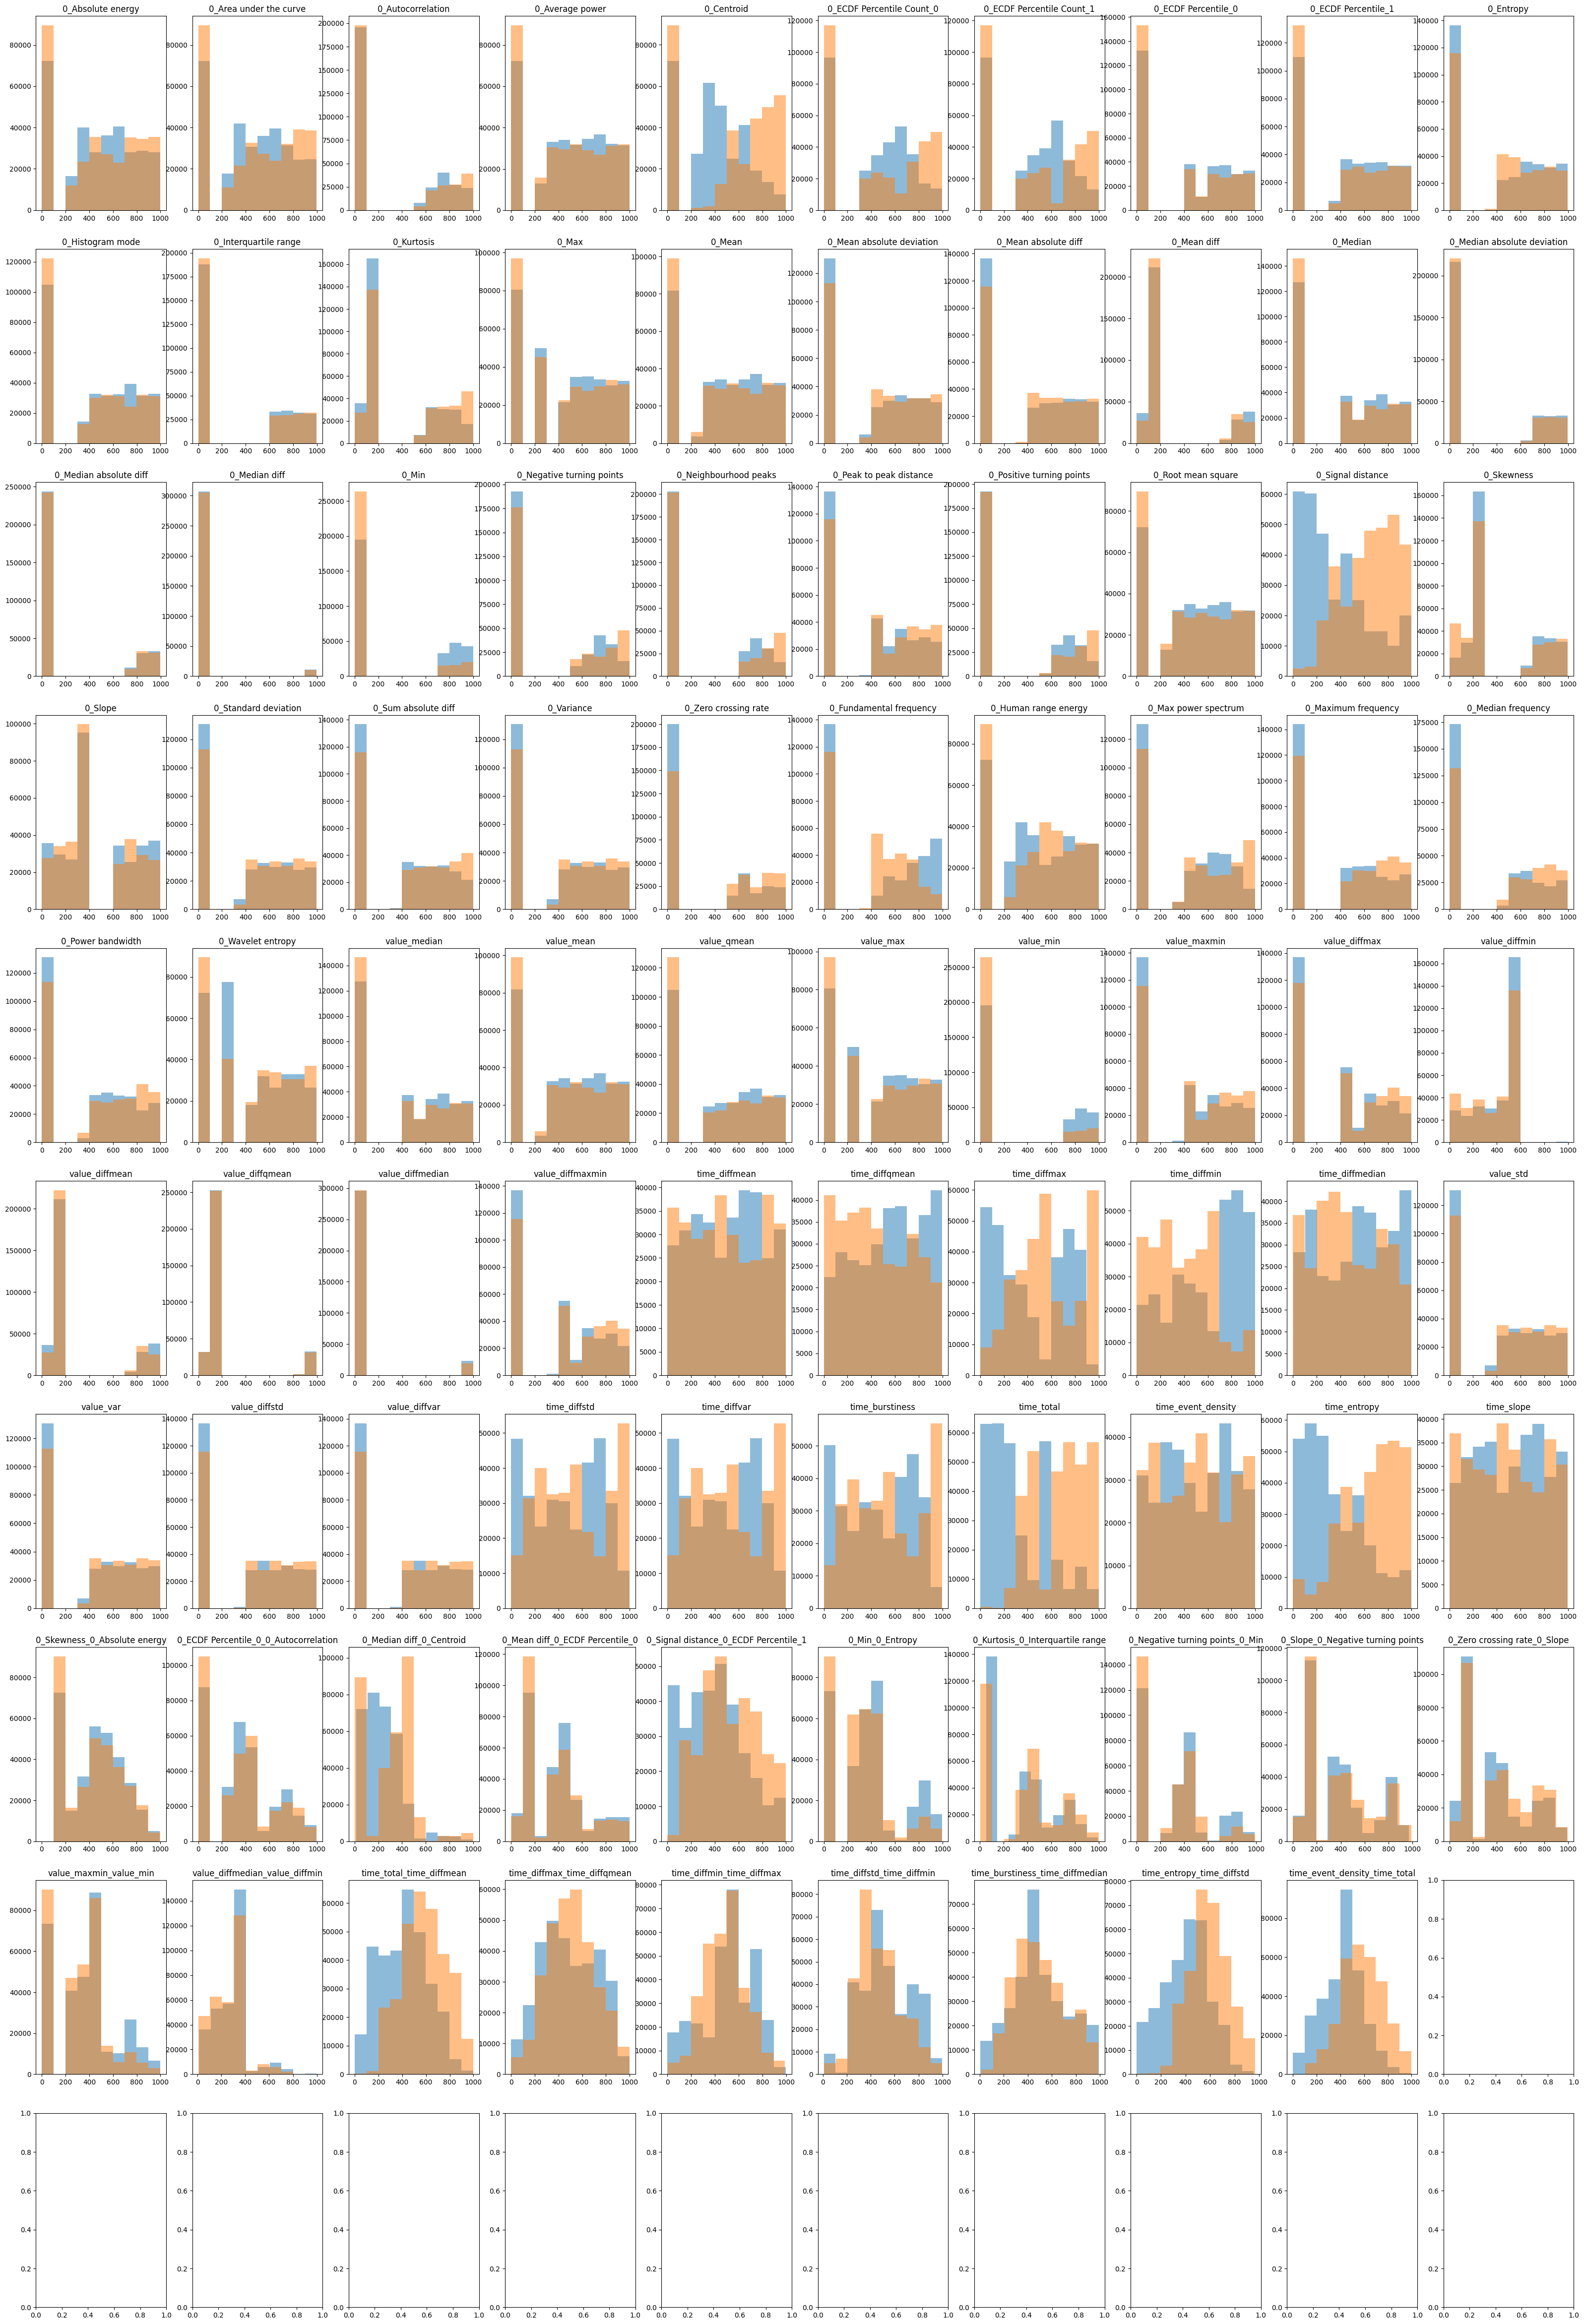

In [22]:
fig, axs = plt.subplots(10, 9, figsize=(40, 60))
axs = axs.flatten()
cols = list(check_trn.columns)

for i, ax in tqdm(enumerate(axs)):
    if i > 88:
        break
    col = cols[i]
    ax.hist(check_trn[col], alpha=0.5)
    ax.hist(check_tst[col], alpha=0.5)
    ax.set_title(col)

plt.show()

# Prepare labels

In [20]:
def get_active_labels_np(row):
    """More efficient version using numpy"""
    arr = row.to_numpy() # convert to numpy array
    indices = np.where(arr == 1)[0] # get indices where value is 1
    labels = row.index[indices].tolist() # get labels from indices
    return labels

labelhir = train_y.apply(get_active_labels_np, axis=1).tolist()

In [21]:
level_labels = [list(train_y.columns[1:]), [], [], [], []]

for k in range(0, 4):
    check_labels = level_labels[k]
    label_len = len(check_labels)
    idx_is_subset_of_col = pd.DataFrame(0, index=check_labels, columns=check_labels)
    is_subset = []

    for i in tqdm(range(label_len), desc=f"Processing level {k}"):
        for j in range(label_len):
            src_lb, tgt_lb = check_labels[i], check_labels[j]
            src = train_y[train_y[src_lb] == 1]
            tgt = train_y[(train_y[src_lb] == 1) & (train_y[tgt_lb] == 1)]

            idx_is_subset_of_col.loc[src_lb, tgt_lb] = len(src) <= len(tgt)
            if len(src) <= len(tgt) and src_lb != tgt_lb:
                is_subset.append([src_lb, tgt_lb])

    remove_label = set([s[0] for s in is_subset])
    
    for rl in remove_label:
        level_labels[k].remove(rl)
        level_labels[k+1].append(rl)

Processing level 3: 100%|██████████| 34/34 [00:01<00:00, 20.31it/s]


In [75]:
level_labels

[['Alarm', 'Command', 'Parameter', 'Sensor', 'Setpoint', 'Status'],
 ['Reset_Setpoint',
  'Usage_Sensor',
  'Pressure_Sensor',
  'Flow_Setpoint',
  'Static_Pressure_Setpoint',
  'Angle_Sensor',
  'Humidity_Setpoint',
  'Temperature_Sensor',
  'Temperature_Setpoint',
  'Supply_Air_Humidity_Sensor',
  'Outside_Air_CO2_Sensor',
  'Differential_Pressure_Setpoint',
  'Damper_Position_Setpoint',
  'Heating_Demand_Setpoint',
  'Cooling_Demand_Setpoint',
  'Current_Sensor',
  'Wind_Speed_Sensor',
  'Flow_Sensor',
  'Dew_Point_Setpoint',
  'Zone_Air_Dewpoint_Sensor',
  'Power_Sensor',
  'Position_Sensor',
  'Solar_Radiance_Sensor',
  'Duration_Sensor',
  'Time_Setpoint',
  'Discharge_Air_Dewpoint_Sensor',
  'Wind_Direction_Sensor',
  'Voltage_Sensor',
  'Zone_Air_Humidity_Sensor',
  'Demand_Sensor',
  'Speed_Setpoint',
  'Rain_Sensor',
  'Frequency_Sensor',
  'Outside_Air_Humidity_Sensor',
  'Outside_Air_Enthalpy_Sensor'],
 ['Air_Flow_Sensor',
  'Water_Temperature_Setpoint',
  'Water_Flow_Senso

In [22]:
tiers = {
    1: level_labels[0],
    2: level_labels[1],
    3: level_labels[2],
    4: level_labels[3],
    5: level_labels[4]
}

def get_tier(label):
    for tier_num, tier_list in tiers.items():
        if label in tier_list:
            return tier_num
    return None  # Handle cases where the label isn't found in any tier

def sort_labels(labels):
    return sorted(labels, key=lambda label: (get_tier(label) or float('inf'), label))


In [23]:
sorted_labelhir = [sort_labels(labels) for labels in labelhir]

In [24]:
label_hier = np.array(
    sorted_labelhir,
    dtype=object,
)

In [25]:
padded_label = pd.Series(label_hier).apply(lambda x: x + ['None'] * (5 - len(x)) if len(x) < 5 else x)

In [26]:
# Count Nones at each level
for i in range(5):
    none_count = sum(padded_label.apply(lambda x: x[i] == 'None'))
    print(f"Level {i+1}: {none_count} None values out of {len(padded_label)} total ({none_count/len(padded_label):.2%})")

Level 1: 0 None values out of 31839 total (0.00%)
Level 2: 12321 None values out of 31839 total (38.70%)
Level 3: 20247 None values out of 31839 total (63.59%)
Level 4: 27216 None values out of 31839 total (85.48%)
Level 5: 30936 None values out of 31839 total (97.16%)


# Model Training

In [27]:
from typing import List

def train_random_forest(
    train_X: List[pd.DataFrame],
    _label,
    folds,
    model_class,
    params: dict,
    none_ratio_thr: float,
):
    """
    Train random forest models using k-fold cross validation
    
    Args:
        train_X: Training features DataFrame
        _label: Array of labels
        folds: List of dictionaries containing train/val indices
        
    Returns:
        tuple: (list of trained classifiers, list of scores, list of validation predictions)
    """
    classifiers = []
    val_feat_df_list = []

    for f_idx, fold in enumerate(folds):
        # Prepare train and validation data for this fold
        train_X_fold_list = []
        train_y_fold_list = []
        for trn_x in train_X:
            train_X_fold_list.append(trn_x.iloc[fold['train']])
            train_y_fold_list.append(_label[fold['train']])

        train_X_fold = pd.concat(train_X_fold_list)
        train_y_fold = np.concatenate(train_y_fold_list)

        valid_X_fold_list = []
        valid_y_fold_list = []
        for trn_x in train_X:
            valid_X_fold_list.append(trn_x.iloc[fold['val']])
            valid_y_fold_list.append(_label[fold['val']])

        val_X_fold = pd.concat(valid_X_fold_list)
        val_y_fold = np.concatenate(valid_y_fold_list)
        
        # Check the train_y_fold. If more than 30% of samples are labeled "None",
        # randomly sample from the "None" to make that ratio no more than 30%.
        none_mask = (train_y_fold == "None")
        none_count = np.sum(none_mask)
        total_samples = len(train_y_fold)
        none_ratio = none_count / total_samples if total_samples > 0 else 0

        if none_ratio > none_ratio_thr:
            # Calculate how many "None" labels we should keep (30% of total)
            max_none_to_keep = int(none_ratio_thr * (total_samples - none_count))

            # Randomly choose which "None" labels to keep
            none_indices = np.where(none_mask)[0]

            # Fix the random seed before shuffling for reproducibility
            rng = np.random.RandomState(f_idx)
            rng.shuffle(none_indices)
            
            keep_none_indices = none_indices[:max_none_to_keep]

            # Indices of all non-"None" labels
            other_indices = np.where(~none_mask)[0]

            # Combine indices to keep and then sort
            new_indices = np.concatenate([keep_none_indices, other_indices])
            new_indices = np.sort(new_indices)  # Sort so we can index the DataFrame consistently

            # Subset the training data
            train_X_fold = train_X_fold.iloc[new_indices]
            train_y_fold = train_y_fold[new_indices]

            # print(f"Sampled: none-ratio: {none_ratio}, removed: {none_count - max_none_to_keep}")

        print(f"Train size: {len(train_X_fold)}, Valid size: {len(val_X_fold)}")
        
        # Create and train Random Forest model
        model = model_class(**params)
        model.fit(train_X_fold, train_y_fold)
        
        classifiers.append(model)
        
        # Calculate score and save predictions on validation set
        val_preds = model.predict_proba(val_X_fold)
        val_pred_df = pd.DataFrame(data=val_preds, columns=model.classes_)

        val_fold_info = []
        for _f in range(len(train_X)):
            f_info = pd.DataFrame(data=fold['val'], columns=["fold_idx"])
            f_info['dataset_idx'] = _f
            val_fold_info.append(f_info)

        val_fold_idx = pd.concat(val_fold_info)
        
        val_feat_df = pd.concat([
            val_fold_idx.reset_index(drop=True),
            val_X_fold.reset_index(drop=True),
            val_pred_df,
        ], axis=1)

        val_feat_df_list.append(val_feat_df)

    return classifiers, val_feat_df_list

def setup_prev_level_prediction(predictions, fold_num, num_datasets):
    new_train_level_x = pd.concat([predictions[i] for i in range(fold_num)]).sort_values(['dataset_idx', 'fold_idx'])
    return [
        new_train_level_x[new_train_level_x['dataset_idx'] == i] \
            .drop(columns=['dataset_idx', 'fold_idx']) \
            .reset_index(drop=True)
        for i in range(num_datasets)
    ]

### Train the high precision model by allowing None prediction

In [28]:
prec_classifiers = []
prec_val_predictions = []

params = {
    'n_estimators': 100,
    'random_state': 42,
    'n_jobs': 8  # Use all available cores
}

model_cls = RandomForestClassifier

none_ratio_thr_list = [0.1, 0.15, 0.35, 0.75, 0.85]

# train_input = [train_X_full, train_X_1, train_X_2]
train_input = train_sets

for i in range(5):
    print(f"Training level {i}")
    _classifiers, _val_predictions = train_random_forest(
        train_input,
        np.array([x[i] for x in padded_label]),
        folds,
        params=params,
        model_class=model_cls,
        none_ratio_thr=none_ratio_thr_list[i]
    )
    prec_classifiers.append(_classifiers)
    prec_val_predictions.append(_val_predictions)

    train_input = setup_prev_level_prediction(_val_predictions, fold_num=len(folds), num_datasets=len(train_input))
    

Training level 0
Train size: 286550, Valid size: 31840
Train size: 286550, Valid size: 31840
Train size: 286550, Valid size: 31840
Train size: 286550, Valid size: 31840
Train size: 286550, Valid size: 31840
Train size: 286550, Valid size: 31840
Train size: 286550, Valid size: 31840
Train size: 286550, Valid size: 31840
Train size: 286550, Valid size: 31840
Train size: 286560, Valid size: 31830
Training level 1
Train size: 202009, Valid size: 31840
Train size: 201951, Valid size: 31840
Train size: 202009, Valid size: 31840
Train size: 201974, Valid size: 31840
Train size: 201997, Valid size: 31840
Train size: 201997, Valid size: 31840
Train size: 202066, Valid size: 31840
Train size: 202020, Valid size: 31840
Train size: 202055, Valid size: 31840
Train size: 202032, Valid size: 31830
Training level 2
Train size: 140818, Valid size: 31840
Train size: 140994, Valid size: 31840
Train size: 141142, Valid size: 31840
Train size: 140791, Valid size: 31840
Train size: 140940, Valid size: 31840

In [57]:
val_pred_res = pd.concat(prec_val_predictions[-1])

# Sort the results with dataset_idx and fold_idx for next level training
val_pred_res = val_pred_res.sort_values(['dataset_idx', 'fold_idx']).reset_index(drop=True)

In [68]:
# Get columns to split tiers
label_start_col_idx = len(combined_feat[0].columns) + 2
col_tiers = [[] for _ in range(5)]

for col in list(val_pred_res.columns)[label_start_col_idx:]:
    ct = get_tier(col)
    if ct == None:
        continue
    col_tiers[ct-1].append(col)

# # keep the label related columns
# # one more column for dataset_idx, one more for fold_idx
val_pred_res = [
    g_df.sort_values("fold_idx").iloc[:, label_start_col_idx:]
    for _, g_df in val_pred_res.groupby("dataset_idx")
]

In [103]:
val_preds_list = []
for i, cols in enumerate(col_tiers):
   tier_preds = []
   for dataset_preds in val_pred_res:
      tier_preds.append(dataset_preds[cols])

   print(i, len(val_preds_list))
   val_preds_list.append(tier_preds)

0 0
1 1
2 2
3 3
4 4


In [98]:
len(col_tiers)

5

In [101]:
val_preds_list[0][0]

,Alarm,Command,Parameter,Sensor,Setpoint,Status
0,0.00,0.0,0.98,0.00,0.02,0.00
1,0.00,0.0,0.36,0.00,0.64,0.00
2,0.00,0.0,0.00,0.99,0.01,0.00
3,0.00,0.0,0.00,1.00,0.00,0.00
4,0.00,0.0,0.05,0.08,0.87,0.00
...,...,...,...,...,...,...
31834,0.00,0.0,0.00,1.00,0.00,0.00
31835,0.08,0.0,0.00,0.07,0.00,0.85
31836,0.00,0.0,0.28,0.36,0.36,0.00
31837,0.00,0.0,0.00,0.00,1.00,0.00


In [76]:
def get_test_agg(test_preds_list):
    test_level_agg = []
    for _level in tqdm(range(5), desc=f"Aggregating predictions"):
        _level_res = pd.concat(test_preds_list[_level], axis=1).groupby(level=0, axis=1).mean()
        assert not _level_res.isna().values.any()

        for col in _level_res.columns:
            _level_res = _level_res.rename(columns={col: f"{col}_{_level}"})

        test_level_agg.append(_level_res)

    return test_level_agg

check = get_test_agg(val_preds_list)

Aggregating predictions: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


In [77]:
check[0]

,Alarm_0,Command_0,Parameter_0,Sensor_0,Setpoint_0,Status_0
0,0.0,0.0,0.98,0.00,0.02,0.00
1,0.0,0.0,0.36,0.00,0.64,0.00
2,0.0,0.0,0.00,0.99,0.01,0.00
3,0.0,0.0,0.00,1.00,0.00,0.00
4,0.0,0.0,0.05,0.08,0.87,0.00
...,...,...,...,...,...,...
318385,0.0,0.0,0.00,1.00,0.00,0.00
318386,0.0,0.0,0.00,0.06,0.00,0.94
318387,0.0,0.0,0.28,0.59,0.13,0.00
318388,0.0,0.0,0.00,0.00,1.00,0.00


In [52]:
for _, gdf in val_pred_res.groupby("dataset_idx"):
    print(gdf.sort_values("fold_idx"))
    break

       fold_idx  dataset_idx  0_Absolute energy  0_Area under the curve   
0             0            0              774.0                   796.0  \
1             1            0              784.0                   832.0   
2             2            0              884.0                   878.0   
3             3            0              968.0                   972.0   
4             4            0              929.0                   944.0   
...         ...          ...                ...                     ...   
31834     31834            0              997.0                   998.0   
31835     31835            0              438.0                   481.0   
31836     31836            0              851.0                   845.0   
31837     31837            0              909.0                   905.0   
31838     31838            0              545.0                   607.0   

       0_Autocorrelation  0_Average power  0_Centroid   
0                  719.0            756.0 

In [79]:
# cliped_test_X = np.clip(test_X, a_min=None, a_max=np.finfo(np.float32).max)
cliped_test_X = test_X

In [80]:
def make_predictions_with_models(classifiers, test_data):
    test_preds_all = []
    for clf in tqdm(classifiers):
        pred = clf.predict_proba(test_data)
        test_preds_all.append(pd.DataFrame(data=pred, columns=clf.classes_))
    return test_preds_all

In [81]:
test_preds_all = make_predictions_with_models(prec_classifiers[0], cliped_test_X)

100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


In [82]:
test_preds_list = []
test_input = cliped_test_X
for i in range(5):
    print(f"Predicting level {i}")
    test_preds_all = make_predictions_with_models(prec_classifiers[i], test_input)

    _level_res = pd.concat(test_preds_all, axis=1).groupby(level=0, axis=1).mean()
    test_input = pd.concat([test_input, _level_res], axis=1)
    
    test_preds_list.append(test_preds_all)

Predicting level 0


100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


Predicting level 1


100%|██████████| 10/10 [00:53<00:00,  5.37s/it]


Predicting level 2


100%|██████████| 10/10 [00:36<00:00,  3.64s/it]


Predicting level 3


100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


Predicting level 4


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


In [86]:
len(test_preds_list[0][0])

315720

In [35]:
test_level_agg = []
for _level in tqdm(range(5)):
    _level_res = pd.concat(test_preds_list[_level], axis=1).groupby(level=0, axis=1).mean()
    assert not _level_res.isna().values.any()

    for col in _level_res.columns:
        _level_res = _level_res.rename(columns={col: f"{col}_{_level}"})

    test_level_agg.append(_level_res)

100%|██████████| 5/5 [00:16<00:00,  3.30s/it]


In [36]:
stacked = np.stack(
    test_level_agg[i].idxmax(axis=1).apply(lambda x: x[:-2])
    for i in range(5)
).transpose()

for row in tqdm(stacked):
    # Find first occurrence of 'None' if any
    none_idx = np.where(row == 'None')[0]
    if len(none_idx) > 0:
        # Set all elements after first None to None
        first_none = none_idx[0]
        row[first_none:] = 'None'
        
stacked

100%|██████████| 315720/315720 [00:02<00:00, 133999.63it/s]


array([['Sensor', 'Power_Sensor', 'None', 'None', 'None'],
       ['Sensor', 'Flow_Sensor', 'Water_Flow_Sensor',
        'Chilled_Water_Supply_Flow_Sensor', 'None'],
       ['Setpoint', 'Temperature_Setpoint', 'None', 'None', 'None'],
       ...,
       ['Sensor', 'Position_Sensor', 'None', 'None', 'None'],
       ['Sensor', 'Power_Sensor', 'Electrical_Power_Sensor', 'None',
        'None'],
       ['Alarm', 'None', 'None', 'None', 'None']], dtype=object)

In [37]:
columnlist = ['Active_Power_Sensor', 'Air_Flow_Sensor',
       'Air_Flow_Setpoint', 'Air_Temperature_Sensor',
       'Air_Temperature_Setpoint', 'Alarm', 'Angle_Sensor',
       'Average_Zone_Air_Temperature_Sensor',
       'Chilled_Water_Differential_Temperature_Sensor',
       'Chilled_Water_Return_Temperature_Sensor',
       'Chilled_Water_Supply_Flow_Sensor',
       'Chilled_Water_Supply_Temperature_Sensor', 'Command',
       'Cooling_Demand_Sensor', 'Cooling_Demand_Setpoint',
       'Cooling_Supply_Air_Temperature_Deadband_Setpoint',
       'Cooling_Temperature_Setpoint', 'Current_Sensor',
       'Damper_Position_Sensor', 'Damper_Position_Setpoint', 'Demand_Sensor',
       'Dew_Point_Setpoint', 'Differential_Pressure_Sensor',
       'Differential_Pressure_Setpoint',
       'Differential_Supply_Return_Water_Temperature_Sensor',
       'Discharge_Air_Dewpoint_Sensor', 'Discharge_Air_Temperature_Sensor',
       'Discharge_Air_Temperature_Setpoint',
       'Discharge_Water_Temperature_Sensor', 'Duration_Sensor',
       'Electrical_Power_Sensor', 'Energy_Usage_Sensor',
       'Filter_Differential_Pressure_Sensor', 'Flow_Sensor', 'Flow_Setpoint',
       'Frequency_Sensor', 'Heating_Demand_Sensor', 'Heating_Demand_Setpoint',
       'Heating_Supply_Air_Temperature_Deadband_Setpoint',
       'Heating_Temperature_Setpoint', 'Hot_Water_Flow_Sensor',
       'Hot_Water_Return_Temperature_Sensor',
       'Hot_Water_Supply_Temperature_Sensor', 'Humidity_Setpoint',
       'Load_Current_Sensor', 'Low_Outside_Air_Temperature_Enable_Setpoint',
       'Max_Air_Temperature_Setpoint', 'Min_Air_Temperature_Setpoint',
       'Outside_Air_CO2_Sensor', 'Outside_Air_Enthalpy_Sensor',
       'Outside_Air_Humidity_Sensor',
       'Outside_Air_Lockout_Temperature_Setpoint',
       'Outside_Air_Temperature_Sensor', 'Outside_Air_Temperature_Setpoint',
       'Parameter', 'Peak_Power_Demand_Sensor', 'Position_Sensor',
       'Power_Sensor', 'Pressure_Sensor', 'Rain_Sensor',
       'Reactive_Power_Sensor', 'Reset_Setpoint',
       'Return_Air_Temperature_Sensor', 'Return_Water_Temperature_Sensor',
       'Room_Air_Temperature_Setpoint', 'Sensor', 'Setpoint',
       'Solar_Radiance_Sensor', 'Speed_Setpoint', 'Static_Pressure_Sensor',
       'Static_Pressure_Setpoint', 'Status', 'Supply_Air_Humidity_Sensor',
       'Supply_Air_Static_Pressure_Sensor',
       'Supply_Air_Static_Pressure_Setpoint', 'Supply_Air_Temperature_Sensor',
       'Supply_Air_Temperature_Setpoint', 'Temperature_Sensor',
       'Temperature_Setpoint', 'Thermal_Power_Sensor', 'Time_Setpoint',
       'Usage_Sensor', 'Valve_Position_Sensor', 'Voltage_Sensor',
       'Warmest_Zone_Air_Temperature_Sensor', 'Water_Flow_Sensor',
       'Water_Temperature_Sensor', 'Water_Temperature_Setpoint',
       'Wind_Direction_Sensor', 'Wind_Speed_Sensor',
       'Zone_Air_Dewpoint_Sensor', 'Zone_Air_Humidity_Sensor',
       'Zone_Air_Humidity_Setpoint', 'Zone_Air_Temperature_Sensor'
]

In [140]:
zipftest = ZipFile('../downloads/test_X_v0.1.0.zip', 'r')
listtestfile = zipftest.namelist()[1:]

In [39]:
stackedfinalresult = pd.DataFrame(columns=['filename'])
stackedfinalresult['filename'] = pd.Series(listtestfile).apply(lambda x: x.split("/")[-1])

for labelname in columnlist:
    stackedfinalresult[labelname] = 0

test_preds = stacked
for i in tqdm(range(len(test_preds))):
    # stackedfinalresult.loc[i, test_preds[i]] = 1
    predlist = test_preds[i].tolist()
    predlist = [x for x in predlist if x != 'None']
    for predlabelname in predlist:
    	stackedfinalresult.loc[i, predlabelname] = 1

100%|██████████| 315720/315720 [01:08<00:00, 4587.06it/s]


In [40]:
stackedfinalresult = stackedfinalresult.assign(**{col: stackedfinalresult[col].astype(float) for col in stackedfinalresult.columns if col != "filename"})

In [41]:
stackedfinalresult.loc[((stackedfinalresult['Peak_Power_Demand_Sensor'] == 1)), 
            'Demand_Sensor'] = 1
stackedfinalresult.loc[((stackedfinalresult['Cooling_Supply_Air_Temperature_Deadband_Setpoint'] == 1)), 
            'Air_Temperature_Setpoint'] = 1
stackedfinalresult.loc[((stackedfinalresult['Heating_Supply_Air_Temperature_Deadband_Setpoint'] == 1)), 
            'Air_Temperature_Setpoint'] = 1

In [42]:
def check_pred_num(_final_res, thr=0.4):
    # Exclude 'filename' column if it exists
    filtered_df = _final_res.drop(columns=['filename'], errors='ignore')

    return (filtered_df >= thr).sum(axis=1)

In [68]:
"""  
1    115878
2    108085
3     61757
4     23471
5      6523
6         5
7         1

1    117837
2     86889
3     65924
4     34575
5     10495

1    115043
2     88383
3     69692
4     31780
5     10822

1    116259
2     96252
3     68733
4     27491
5      6985
"""
check_pred_num(stackedfinalresult, thr=0.35).value_counts()

1    115339
2     87996
3     69755
4     30163
5     12380
6        87
Name: count, dtype: int64

In [70]:
stackedfinalresult.to_csv("../logs/submit/0126_0547_label_warp.csv", index=False)

In [45]:
stackedfinalresult

,filename,Active_Power_Sensor,Air_Flow_Sensor,Air_Flow_Setpoint,Air_Temperature_Sensor,Air_Temperature_Setpoint,Alarm,Angle_Sensor,Average_Zone_Air_Temperature_Sensor,Chilled_Water_Differential_Temperature_Sensor,...,Warmest_Zone_Air_Temperature_Sensor,Water_Flow_Sensor,Water_Temperature_Sensor,Water_Temperature_Setpoint,Wind_Direction_Sensor,Wind_Speed_Sensor,Zone_Air_Dewpoint_Sensor,Zone_Air_Humidity_Sensor,Zone_Air_Humidity_Setpoint,Zone_Air_Temperature_Sensor
0,test_X20367.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,test_X103084.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,test_X6910.pkl,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,test_X66332.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,test_X38528.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315715,test_X325790.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
315716,test_X61444.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
315717,test_X221284.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
315718,test_X115827.pkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
freq_check = []
for col in train_y.columns[1:]:
    freq_check.append([get_tier(col), col, len(train_y[train_y[col] == 1])])

freq_check = pd.DataFrame(freq_check, columns=['tier', 'col', 'count'])
freq_check[['tier', 'count']].groupby('tier').agg('sum') / len(train_y)

,count
tier,
1,1.000000
2,0.628286
3,0.365589
4,0.145199
5,0.011590


In [80]:
freq_check = []
for col in stackedfinalresult.columns[1:]:
    freq_check.append([get_tier(col), col, len(stackedfinalresult[stackedfinalresult[col] == 1])])

freq_check = pd.DataFrame(freq_check, columns=['tier', 'col', 'count'])
freq_check[['tier', 'count']].groupby('tier').agg('sum') / len(stackedfinalresult)

,count
tier,
1,1.000000
2,0.645284
3,0.353060
4,0.137055
5,0.018516


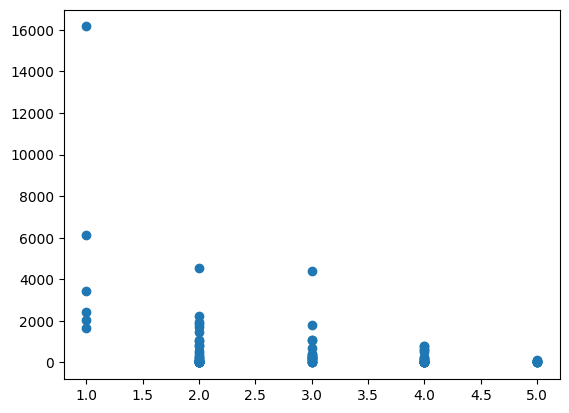

In [72]:
plt.scatter(freq_check['tier'], freq_check['count'])

### Check occurence

In [46]:
check = stackedfinalresult.copy()
occurence = []

for col1 in tqdm(list(check.columns)[1:]):
    for col2 in list(check.columns)[1:]:
        if col1 != col2:
            oc = check[[col1, col2]]
            oc = oc[(oc[col1] == 1) & (oc[col2] == 1)]
            occurence.append([col1, col2, len(oc)])

100%|██████████| 94/94 [00:21<00:00,  4.35it/s]


In [49]:
trn_oc_check = train_y.copy()
trn_occurence = []

for col1 in tqdm(list(trn_oc_check.columns)[1:]):
    for col2 in list(trn_oc_check.columns)[1:]:
        if col1 != col2:
            oc = trn_oc_check[[col1, col2]]
            oc = oc[(oc[col1] == 1) & (oc[col2] == 1)]
            trn_occurence.append([col1, col2, len(oc)])

100%|██████████| 94/94 [00:12<00:00,  7.33it/s]


In [52]:
trn_oc = pd.DataFrame(trn_occurence)
trn_oc = trn_oc[trn_oc[2] > 0]

In [53]:
oc_check = pd.DataFrame(occurence)
oc_check = oc_check[oc_check[2] > 0]

In [61]:
oc_check[2].sum()

1186338

In [62]:
1186338 - 1125680

60658

In [60]:
pd.merge(oc_check, trn_oc, on=[0, 1])['2_x'].sum()

1125680

,0,1,2
29,Active_Power_Sensor,Electrical_Power_Sensor,621
56,Active_Power_Sensor,Power_Sensor,621
64,Active_Power_Sensor,Sensor,621
125,Air_Flow_Sensor,Flow_Sensor,678
157,Air_Flow_Sensor,Sensor,678
...,...,...,...
8652,Zone_Air_Temperature_Sensor,Air_Temperature_Sensor,804
8656,Zone_Air_Temperature_Sensor,Average_Zone_Air_Temperature_Sensor,102
8714,Zone_Air_Temperature_Sensor,Sensor,804
8726,Zone_Air_Temperature_Sensor,Temperature_Sensor,804


In [145]:
import numpy as np

pred_idx = np.load("../logs/0129_prob_ensemble_class_weight.npy")

In [146]:
pred_res = np.zeros((len(listtestfile), len(columnlist)))
pred_res[pred_idx[0], pred_idx[1]] = 1.0

In [147]:
semi_pred_filename = pd.DataFrame(columns=['filename'])
semi_pred_filename['filename'] = pd.Series(listtestfile).apply(lambda x: x.split("/")[-1])

semi_pred_res = pd.DataFrame(data=pred_res, columns=columnlist)

semi_pred_res = pd.concat([semi_pred_filename, semi_pred_res], axis=1)

In [144]:
def check_pred_num(_final_res, thr=0.4):
    # Exclude 'filename' column if it exists
    filtered_df = _final_res.drop(columns=['filename'], errors='ignore')

    return (filtered_df >= thr).sum(axis=1)

check_pred_num(semi_pred_res, thr=0.35).value_counts()

1    118469
2     79953
3     74064
4     31937
5     11297
Name: count, dtype: int64

In [148]:
check_pred_num(semi_pred_res, thr=0.35).value_counts()

1    119405
2     82247
3     71922
4     31935
5     10211
Name: count, dtype: int64

In [149]:
semi_pred_res.to_csv("../logs/submit/0129_15_aug_class_weight.csv", index=False)